In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.backends.cudnn as cudnn

from tqdm import tqdm 

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path

import utils_data, utils_spikes, utils_events, utils_tensor, utils_pcn 

# The paper says the dish is a predictive network, we are going to be more ambitious and actually prove it is one 
### But we'll start with MNIST first because we're not THAT ambitious

## See [this paper](https://pubmed.ncbi.nlm.nih.gov/28333583/) for the maths

### We define the layer

In [3]:
# Define the fully connected (dense) layer class
class FCLayer(object):
    # -- INIT -- #
    # Initialize the fully connected layer with input size, output size, activation function, and its derivative
    def __init__(self, input_size, output_size,
                f, df, device, dtype = torch.float64):
        self.input_size = input_size  # layer input size
        self.output_size = output_size  # layer output size
        self.f = f  # activation function
        self.df = df  # derivative of activation function
        self.device = device  # cuda or cpu
        self.dtype = dtype

        # Weights initialization, as normal random variables
        self.weights = torch.empty([self.input_size, self.output_size], dtype = self.dtype).normal_(mean=0.0, std=0.05).to(self.device)

    # -- NETWORK ACTIVATION -- #
    # Forward activation pass, multiplying an input x by the weights and passing them through the activation function
    # Note that this makes the layer object keep x as .inp and x*weights as .activations
    def forward(self, x):
        self.inp = x.clone()
        self.activations = torch.matmul(self.inp, self.weights)
        return self.f(self.activations)

    # Derivative backward activation pass, multiplying the input by the activation derivation and weight matrix
    def backward(self, x):
        self.fn_deriv = self.df(self.activations)
        out = torch.matmul(x * self.fn_deriv, self.weights.T)
        return out

### Define the network

In [4]:
class PCNet_Bogacz(object):
    def __init__(self, layers, n_inferences_steps, mu_lr,
                theta_lr, batch_size,
                fixed_predictions, update_weights_flag,
                weight_clamp, pi_lr, pi_clamp,
                mu_clamp, do_pi, device,
                dtype = torch.float64):

        self.layers = layers  # list of layers in the network
        self.batch_size = batch_size  # batch size
        self.n_inferences_steps = n_inferences_steps  # number of steps in inference

        self.fixed_predictions = fixed_predictions  # flags: update predictions
        self.update_weights_flag = update_weights_flag  # flags: update weights
        self.do_pi = do_pi  # flags: compute precision after the torch.eye init

        self.mu_lr = mu_lr  # mu's shift rate
        self.mu_clamp = mu_clamp  # clamp of mu values
        
        self.theta_lr = theta_lr  # theta learning rate
        self.weight_clamp = weight_clamp  # clamp of theta value
        
        self.pi_lr = pi_lr  # pi learning rate
        self.pi_clamp = pi_clamp  # clamp of pi value

        self.device = device  # cuda or cpu
        self.dtype = dtype
        self.inited_pi = False  # switches off after precision init

        # Initialize the lists of values
        self.L = len(self.layers)
        self.outs = [[] for i in range(self.L + 1)]  # forward activations
        self.prediction_errors = [[] for i in range(self.L + 1)]  # prediction errors
        self.predictions = [[] for i in range(self.L + 1)]  # predictions
        self.mus = [[] for i in range(self.L + 1)]  # value neurons
        
        self.inhs = [[] for i in range(self.L + 1)]  # inhibitory neurons 
        self.inh_ws = [[] for i in range(self.L + 1)]  # inhibitor weights
        
        for i in range(1, self.L + 1):
            self.inh_ws[i] = torch.eye(self.layers[i-1].output_size, dtype=torch.float64, device=device).unsqueeze(0).repeat(self.batch_size, 1, 1)
        
    # This is the meta function
    @torch.no_grad()
    def run_pc(self, inp, label):
        # Set the initial value neurons for input and label
        inp = inp.to(self.dtype)
        self.mus[0] = inp.clone()
        for i in range(1, self.L):
            self.mus[i] = self.layers[i - 1].forward(self.mus[i - 1])
        self.mus[-1] = label.clone()

        # And propagate them through the network
        for i in range(1, self.L + 1):
            self.outs[i] = self.layers[i-1].forward(self.mus[i-1])     
            self.prediction_errors[i] = torch.zeros_like(self.outs[i], device = self.device, dtype = self.dtype)
            self.inhs[i] = torch.zeros_like(self.prediction_errors[i], device = self.device, dtype = self.dtype)
            
        # Then perform the inference steps to reduce prediction errors
        for _ in range(self.n_inferences_steps):
            for j in range(1, self.L):
                self.predictions[j] = self.layers[j].df(self.layers[j].activations)
                dx_l = - self.prediction_errors[j] + torch.matmul(self.prediction_errors[j+1] * self.predictions[j], self.layers[j].weights.T)
                self.mus[j] += self.mu_lr * torch.clamp(dx_l, -self.mu_clamp, self.mu_clamp)
                
            # Update once again the prediction errors - and the prediction, if they are not fixed
            for i in range(1, self.L + 1):
                self.prediction_errors[i] += self.mus[i] - self.outs[i]
                self.prediction_errors[i] -= self.inhs[i]
                self.inhs[i] += torch.bmm(self.inh_ws[i], self.prediction_errors[i].unsqueeze(2)).squeeze(2) - self.inhs[i]
                
                if not self.fixed_predictions:
                    self.outs[i] = self.layers[i - 1].forward(self.mus[i - 1])

        # Then do the slow weight updates
        for (i, l) in enumerate(self.layers):
            layer_term = self.prediction_errors[i + 1] * l.df(l.activations)
            dw = torch.matmul(l.inp.T, layer_term)
            l.weights += self.theta_lr * torch.clamp(dw, -self.weight_clamp, self.weight_clamp)

        # and inhibitory weights updates
        if self.do_pi:
            for i in range(1, self.L + 1):
                d_inh_w = torch.bmm(self.prediction_errors[i].unsqueeze(2), self.inhs[i].unsqueeze(1)).squeeze(0)
                d_inh_w -= torch.eye(self.prediction_errors[i].shape[1], device=self.device, dtype = self.dtype).unsqueeze(0).repeat(self.batch_size, 1, 1)
                self.inh_ws[i] += self.pi_lr * torch.clamp(d_inh_w, -self.pi_clamp, self.pi_clamp)

        # Calculate the Free Energy (F) --> see Millidge's review equation 11
        squared_L = 0
        for i in range(1, self.L + 1):
            # covars = torch.cov(self.prediction_errors[i].T + 1e-6)
            # l = torch.sum(torch.matmul(covars.inverse(),self.prediction_errors[i].unsqueeze(2)**2).squeeze(2))
            # l += torch.log(2*torch.pi*torch.sum(covars))
            l = torch.sum(self.prediction_errors[i]**2)
            squared_L += l

        # Compute the accuracy of the model
        acc = utils_pcn.accuracy(nograd_forward(self, inp), label)

        # Return the Free Energy and accuracy
        return squared_L.cpu().item(), acc
    
    @torch.no_grad()
    def soft_generate(self, y, df, n_generative_steps=1):
        # Set the initial mus for y
        y = y.to(self.dtype)

        # Perform generative steps n_generative_steps times
        for _ in range(n_generative_steps):
            self.mus[-1] = y.clone()

            # Perform backward pass
            for i in range(self.L, 0, -1):
                # Compute prediction and prediction error
                self.predictions[i] = self.layers[i - 1].df(self.layers[i - 1].activations)
                self.prediction_errors[i] = self.mus[i] - self.layers[i - 1].forward(self.mus[i - 1])

                # Compute dx using df passed as argument instead of hardcoded arctan
                dx_l = df(self.layers[i - 1].activations) * torch.matmul(self.prediction_errors[i], self.layers[i - 1].weights.T)

                # Update mus
                self.mus[i - 1] += self.mu_lr * torch.clamp(dx_l, -self.mu_clamp, self.mu_clamp)

        return self.mus[0]

    @torch.no_grad()
    def hard_generate(self, y, n_generative_steps=1):
        # Set the initial mus for y
        y = y.to(self.dtype)

        # Perform generative steps n_generative_steps times
        for _ in range(n_generative_steps):
            self.mus[-1] = y.clone()

            # Propagate the activation down to the input layer
            for i in range(self.L - 1, -1, -1):
                self.mus[i] = self.layers[i].backward(self.mus[i + 1])
        
        return self.mus[0]


### And some utils to save us time 

In [5]:
# Main training function to run everything
def train(model, trainset, testset, n_epochs):
    with torch.no_grad():
        losses = []
        accs = []
        test_accs = []
        for epoch in tqdm(range(n_epochs), total = n_epochs, desc = 'Training ...', position = 0, leave = True):
            losslist, acclist = [], []
            for i, (inp, label) in enumerate(trainset):
                oh_label = utils_pcn.onehot(label, model.device).to(model.device)
                squared_L, acc = model.run_pc(inp.to(model.device), oh_label)
                losslist.append(squared_L)
                acclist.append(acc)
                
            losses.append(np.mean(np.array(losslist)))
            accs.append(np.mean(np.array(acclist)))

            #print('Avg loss on epoch %s' % self.losses[-1])
            #print('Avg acc on epoch %s' % self.accs[-1])

            mean_test_acc, _ = test_accuracy(model, testset)
            test_accs.append(mean_test_acc)
            # self.save_model(model = model, precision_type = precision_type)
    return losses, accs, test_accs

# Forward through the network without gradient computation
def nograd_forward(model, x):
    with torch.no_grad():
        for i, l in enumerate(model.layers):
            x = l.forward(x)
        return x

# Save the model
def save_model(model, precision_type):
    for i, l in enumerate(model.layers):
        np.save('./data/weights/layer_%s' % i, l.weights.cpu().detach().numpy())
        if precision_type == 'regular' :
            np.save('./data/precisions/layer_%s' % i, model.pis[i].cpu().detach().numpy())
        else :
            print('Precision type %s not implemented, not saving precision matrices' % precision_type)

# Compute test accuracy
def test_accuracy(model, testset):
    accs = []
    for i, (inp, label) in enumerate(testset):
        pred_y = nograd_forward(model, inp.to(model.device, dtype = model.dtype))
        acc = utils_pcn.accuracy(pred_y, utils_pcn.onehot(label, model.device).to(model.device))
        accs.append(acc)
    return np.mean(np.array(accs)), accs


# Now the parameters

In [6]:
# Input parameters
batch_size = 64  # Batch size
norm_factor = 1  # Normalization factor

# Learning parameters
epochs = 30  # iterations of the full inference steps
n_inferences_steps = 500  # number of inference steps per input
n_generative_steps = 100 # number of generative steps per input

# Theta (weights) parameters
theta_lr = 0.005  # learning rate for the weights theta
weight_clamp = 50  # weight clamp

# Mu (values) parameters
mu_lr = 0.02  # shift rate for the value neurons
mu_clamp = 1000  # value neuron clamp

# Pi (precision) parameters
pi_lr = 5e-5  # learning rate for the precision pi
pi_clamp = 0.05  # precision clamp

# Layer parameter
update_weights_flag = True  # whether to learn the FF weights
f = utils_pcn.tanh
df = utils_pcn.tanh_deriv

# Network parameter
L1_size = 256
L2_size = 128
L3_size = 256
fixed_predictions = True  # change the predictions or not


# Torch parameters 
num_workers = 16
pin_memory = True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
cudnn.benchmark = True

cuda


# And off we go

In [8]:
# Generating datasets
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data/mnist_data', train=True,
                                    download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers = num_workers, pin_memory = pin_memory)

testset = torchvision.datasets.MNIST(root='./data/mnist_data', train=False,
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=True, num_workers = num_workers, pin_memory = pin_memory)

testset = list(iter(testloader)) # this is just because I did a terrible implementation of PCNet
trainset = list(iter(trainloader))

for i, (img, label) in enumerate(trainset[:-2]) :
    trainset[i] = (torch.Tensor(img).reshape(len(img), 784).to(torch.float64), label)
    
for i, (img, label) in enumerate(testset[:-2]) :
    testset[i] = (torch.Tensor(img).reshape(len(img), 784).to(torch.float64), label)

# Building the network
shapes = [trainset[0][0].shape[1], L1_size, L2_size, L3_size, 10]
layers = []
for i in range(len(shapes)-1) :
    print('Layer', i, ' : ', shapes[i], ' -> ', shapes[i+1])
    layers.append(FCLayer(input_size = shapes[i],
                            output_size = shapes[i+1], f = f, df = df,
                            device = device))
    

model = PCNet_Bogacz(layers = layers, batch_size = batch_size,
                        n_inferences_steps = n_inferences_steps,
                        mu_lr = mu_lr, theta_lr = theta_lr, pi_lr = pi_lr,
                        fixed_predictions = fixed_predictions, update_weights_flag=update_weights_flag,
                        weight_clamp = weight_clamp, mu_clamp = mu_clamp,  pi_clamp = pi_clamp,
                        device = device, do_pi = False)

# GPU burning
losses, accs, test_accs = train(model = model, 
                                trainset = trainset[0:-2], testset = testset[0:-2],
                                n_epochs = epochs)

Layer 0  :  784  ->  256
Layer 1  :  256  ->  128
Layer 2  :  128  ->  256
Layer 3  :  256  ->  10


Training ...: 100%|██████████| 50/50 [2:16:07<00:00, 163.36s/it]  


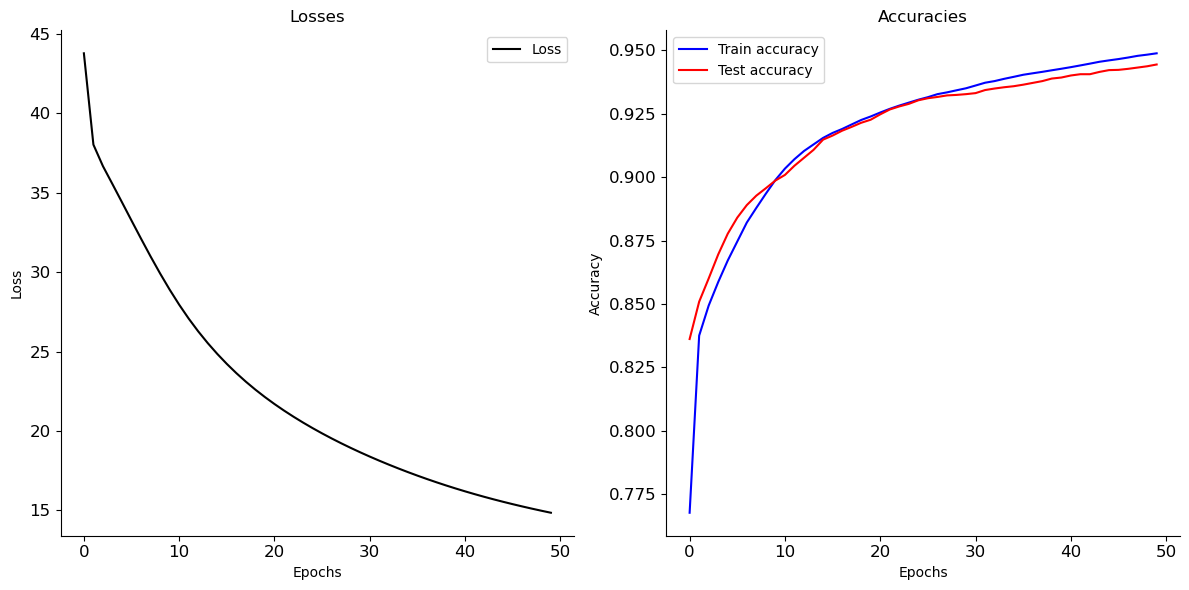

In [9]:
# ------------------- Plotting ------------------- #
fig, axs = plt.subplots(figsize = (12,6), ncols = 2)

axs[0].plot(losses, c = 'k', label = 'Loss')
axs[0].set_title('Losses')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(accs, c = 'b', label = 'Train accuracy')
axs[1].plot(test_accs, c = 'r', label = 'Test accuracy')
axs[1].set_title('Accuracies')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

for ax in axs :
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=12)
    
fig.tight_layout()
plt.show()

# Generative mode now

output_size = 10
initial_activation = torch.randn([batch_size, output_size], device = device) # for example, random noise
generated_data = model.soft_generate(y = initial_activation, n_generative_steps=n_generative_steps, df = df)

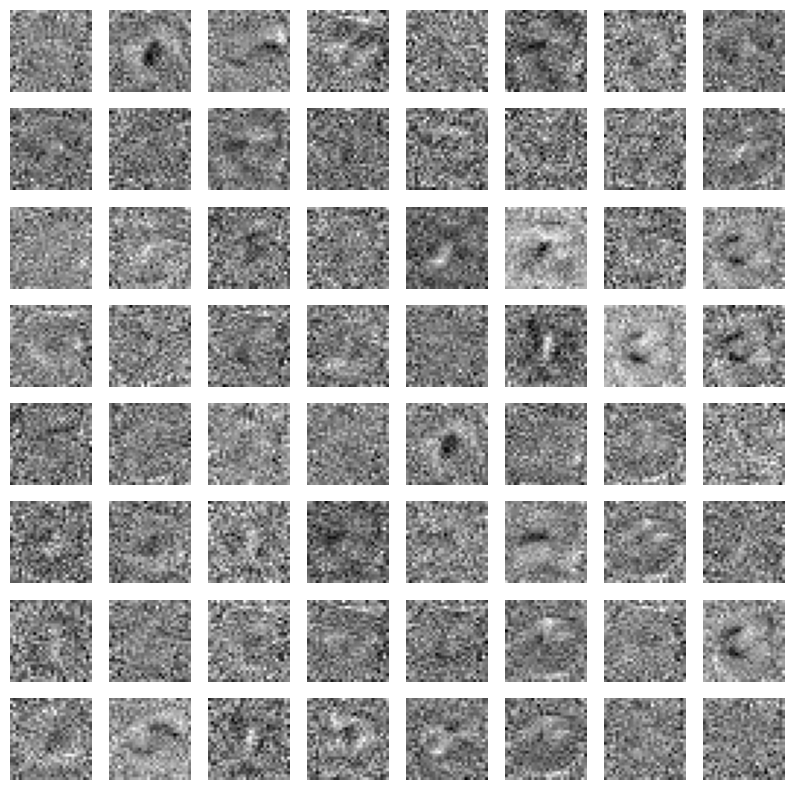

In [13]:
one_hot_matrix = torch.eye(10, device = device)
labels = torch.randint(10, size = (batch_size,), device = device)
one_hot_vectors = one_hot_matrix[labels]
gen_imgs = model.hard_generate(y = one_hot_vectors, 
                            n_generative_steps = n_generative_steps) 

fig, axs = plt.subplots(figsize = (10,10), ncols = np.sqrt(batch_size).astype(int), nrows = np.sqrt(batch_size).astype(int))
for iax, ax in enumerate(axs.flatten()) :
    ax.imshow(gen_imgs[iax,:].reshape(28,28).cpu().detach().numpy(), cmap = 'gray')
    ax.axis('off')
plt.show()